# 灰色预测模型

## GM(1,1) 预测模型

GM(1,1) 表示模型时一阶微分方程，且只含有一个变量的灰色模型

### GM(1,1) 预测方法

#### 1、检验数据

已知参考数据列
$$
x^{(0)}=\{x^{(0)}(i)\},i=1,2,\cdots,n
$$
计算序列的级比
$$
\lambda(k)=\frac{x^{(0)}(k-1)}{x^{(0)}(k)},k=2,3,\cdots,n
$$
若 $\forall\quad\lambda(k)\in(e^{-\frac{2}{n+1}},e^{\frac{2}{n+1}})$ 则序列 $x^{(0)}$ 可作为模型数据进行预测，否则必须进行变换处理，选取常数 $c$ 进行平移变换
$$
y^{(0)}(k)=x^{(0)}(k) + c
$$
使得其级比满足要求



#### 2、建立模型

已知参考数据列
$$
x^{(0)}=\{x^{(0)}(i)\},i=1,2,\cdots,n
$$
得到 1 次累加生成序列
$$
x^{(1)}=\{x^{(1)}(i)=\mathop{\Sigma}\limits_{k=1}^ix^{(0)}\}, i=1,2,\cdots,n
$$
得到 $x^{(1)}$ 的均值生成序列
$$
z^{(1)}=\{z^{(1)}(i)=0.5x^{(1)}(i)+0.5x^{(1)}(i-1)\}, i=2,3,\cdots,n
$$
建立灰微分方程
$$
x^{(0)}(k)+az^{(1)}(k)=b,k=2,3,\cdots,n
$$
相应的白化微分方程
$$
\frac{dx^{(1)}}{dt}+ax^{(1)}(t)=b
$$
记 $u=[a,b]^T$，$Y=[x^{(0)}(2),x^{(0)}(3),\cdots,x^{(0)}(n)]^T$，$B=\begin{bmatrix}-z^{(1)}(2)&1\\-z^{(1)}(3)&1\\\vdots&\vdots\\-z^{(1)}(n)&1\end{bmatrix}$​，有
$$
J(u)=(Y-Bu)^T(Y-Bu)
$$
使得 $J(u)$ 达到最小值的估计值为
$$
\widehat{u}=[\widehat{a},\widehat{b}]^T=(B^TB)^{-1}B^TY
$$
可得到
$$
\widehat{x}^{(1)}(k+1)=(x^{(0)}(1)-\frac{\widehat{b}}{\widehat{a}})e^{-\widehat{a}k}+\frac{\widehat{b}}{\widehat{a}},k=0,\cdots,n-1,\cdots
$$

#### 3、检验预测值

1. 残差检验
   $$
   \epsilon(k)=\frac{x^{(0)}(k)-\widehat{x}^{(0)}(k)}{x^{(0)}(k)},k=1,2,\cdots,n
   $$
   若 $\epsilon(k)<0.2$ 则达到一般要求，若 $<0.1$ 则达到较高要求

2. 级比偏差检验

   首先算出级比 $\lambda$，随后计算
   $$
   \rho(k)=1-(\frac{1-0.5a}{1+0.5a})\lambda(k)
   $$
   若 $\rho(k)<0.2$ 达到一般要求，$<0.1$ 达到较高要求


### 实例
北方某城市 1986-1992 年道路交通噪声平均声级数据见下表

In [106]:
import numpy as np
import pandas as pd
data = np.array([71.1, 72.4, 72.4, 72.1, 71.4, 72.0, 71.6])
data = np.concatenate((np.arange(1986, 1993).reshape(-1, 1), data.reshape(-1, 1)), axis=1)
df = pd.DataFrame(data)
df.columns = ['年份', '噪声(dB)']
df

,年份,噪声(dB)
0,1986.0,71.1
1,1987.0,72.4
2,1988.0,72.4
3,1989.0,72.1
4,1990.0,71.4
5,1991.0,72.0
6,1992.0,71.6


1. 级比检验

In [107]:
import math
x = data[:, 1]
lmda = [x[i]/x[i+1] for i in range(len(x)-1)]

ulim = math.exp(2/(len(x)+1))
dlim = math.exp(-2/(len(x)+1))

print(min(lmda),max(lmda), ulim, dlim)

0.9820441988950275 1.0098039215686272 1.2840254166877414 0.7788007830714049


满足级比检验

2. 建模

In [108]:
x1 = x.copy()
z1 = np.zeros_like(x)
for i in range(1, len(x1)):
    x1[i] += x1[i-1]
    z1[i] = (x1[i] + x1[i-1])/2
B = np.concatenate((-z1[1:].reshape(-1, 1), (np.ones_like(z1))[1:].reshape(-1, 1)), axis=1)
Y = x[1:].reshape(-1, 1)

u = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(Y)
u

array([[2.34378648e-03],
       [7.26572696e+01]])

有
$$
\begin{aligned}
\widehat{x}^{(1)}(k+1)&=(x^{(0)}(1)-\frac{\widehat{b}}{\widehat{a}})e^{-\widehat{a}k}+\frac{\widehat{b}}{\widehat{a}},k=0,\cdots,n-1,\cdots\\
&71.1-30997)e^{-0.002344k}+30997\\
&=-30925.9e^{-0.002344k}+30997
\end{aligned}
$$


3. 预测

In [109]:
def predict(k):
    return -30926*np.exp(-0.002344*k) + 30997

pre_x1 = predict(np.arange(len(x)))
df['预测值'] = [pre_x1[0], *[pre_x1[i+1] - pre_x1[i] for i in range(len(pre_x1) - 1)]]
df['残差'] = df['预测值'] - df['噪声(dB)']
df['相对误差'] = df['残差']/df['噪声(dB)']
lmda.insert(0, 0)
a = (1 - 0.5*0.002344)/(1 + 0.5*0.002344)
df['级比偏差'] = 1 - np.multiply(a, lmda)
df

,年份,噪声(dB),预测值,残差,相对误差,级比偏差
0,1986.0,71.1,71.000000,-0.100000,-0.001406,1.000000
1,1987.0,72.4,72.405651,0.005651,0.000078,0.020255
2,1988.0,72.4,72.236131,-0.163869,-0.002263,0.002341
3,1989.0,72.1,72.067008,-0.032992,-0.000458,-0.001810
4,1990.0,71.4,71.898281,0.498281,0.006979,-0.007440
5,1991.0,72.0,71.729949,-0.270051,-0.003751,0.010655
6,1992.0,71.6,71.562011,-0.037989,-0.000531,-0.003232


可以发现残差以及级比偏差均小于 0.1，达到较高预测要求

GM(1,1) 模型适用于具有较强质数规律的序列，只能描述单调的变化过程，对于非单调的摆动发展序列或有饱和的 S 型序列，可以考虑建立 GM(2,1)、DGM 和 Verhulst 模型

以下不再赘述数学模型，贴代码
### GM(2,1) 模型

In [110]:
import numpy as np
x = np.array([41, 49, 61, 78, 96, 104])

# 得到 1 次累加生成序列
x1 = x.copy()
for i in range(len(x) - 1):
    x1[i+1] += x1[i]
print('x1: ', x1)

# 得到 1 次累减生成序列
ax = x.copy()
for i in range(len(x) - 1):
    ax[i+1] = x[i+1] - x[i]

# x1 的均值生成序列
z = np.zeros_like(x, dtype=np.float64)
for i in range(len(x) - 1):
    z[i+1] = (x1[i+1] + x1[i])/2.0

# 求解最小二乘法
B = np.concatenate((-x[1:].reshape(-1, 1), -z[1:].reshape(-1, 1), np.ones((len(x)-1, 1))), axis=1)
Y = ax[1:].reshape(-1, 1)
u = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(Y)

# u = [a1, a2, b].T
print('u: ', u)

x1:  [ 41  90 151 229 325 429]
u:  [[ -1.09219635]
 [  0.19590335]
 [-31.79834712]]


得到白化模型
$$
\frac{d^2x^{(1)}}{dt^2} + a_1\frac{dx^{(1)}}{dt} + a_2x^{(1)} = b
$$
即
$$
y^{''}-1.0922y^{'}+0.1959y = -31.7983\\
def\quad y=x^{(1)}
$$
同时拥有边界条件
$$
y(1) = 41\\
y(6) = 429
$$
进行求解

In [111]:
import sympy

# 定义符号
t = sympy.symbols("t", positive=True)
y = sympy.Function('y')

# 定义方程
ode = y(t).diff(t, 2) + u[0]*y(t).diff(t, 1) + u[1]*y(t) - u[2]
# 得到通解
ode_sol = sympy.dsolve(ode)[0]
# 定义边界条件
ics = {y(1): 41, y(6): 429}
# 得到特接
eqs = [
    (ode_sol.lhs - ode_sol.rhs).subs(t, 1).subs(ics),
    (ode_sol.lhs - ode_sol.rhs).subs(t, 6).subs(ics)
]
free_params = ode_sol.free_symbols - {t}
sol_params = sympy.solve(eqs, free_params)
y_t_sol = ode_sol.subs(sol_params)

y_t_sol

Eq(y(t), 162.577722971712*exp(0.226223404169042*t) - 0.223994340679972*exp(0.865972945416788*t) - 162.316507096964)

In [126]:
# 得到数值函数，且进行误差预测
fy = sympy.lambdify(t, y_t_sol.rhs)
px1 = fy(np.arange(1, 7))
px0 = np.array([px1[0], *[px1[i+1] - px1[i] for i in range(len(px1) - 1)]])

df = pd.DataFrame((x, px0)).T
df.columns = ['实际数据', '预测数据']
df['残差'] = df['实际数据'] - df['预测数据']
df['相对误差'] = df['残差'] / df['实际数据']
df

,实际数据,预测数据,残差,相对误差
0,41.0,41.000000,1.705303e-13,4.159275e-15
1,49.0,51.014814,-2.014814e+00,-4.111866e-02
2,61.0,63.141238,-2.141238e+00,-3.510226e-02
3,78.0,77.211140,7.888598e-01,1.011359e-02
4,96.0,92.154790,3.845210e+00,4.005427e-02
5,104.0,104.478018,-4.780179e-01,-4.596326e-03


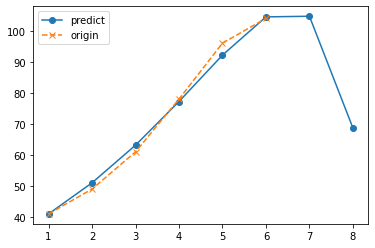

In [152]:
import matplotlib.pyplot as plt
px0 = np.arange(1, 9)
py00 = fy(px0)
py0 = py00.copy()
for i in range(1, len(py00)):
    py0[i] = py00[i] - py00[i-1]
px1 = np.arange(1, 7)

plt.plot(px0, py0, '-o', label='predict')
plt.plot(px1, x, '--x', label='origin')
plt.legend()